<a href="https://colab.research.google.com/github/wesleiferreira98/kNN-no-Instagram/blob/main/Projeto_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler, MaxAbsScaler, Normalizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import seaborn as sns
import matplotlib.pyplot as plt
import gdown

In [2]:
# URL do Google Drive
url = 'https://drive.google.com/uc?id=1MD0tpQI27v-Jmm9ZNFukUJPi0_KUn5_i'

# Caminho para salvar o arquivo temporariamente
output = '/tmp/top_insta_influencers_data.csv'

# Baixar o arquivo
gdown.download(url, output, quiet=False)

# Carregar o arquivo em um DataFrame
df = pd.read_csv(output)

# Exibindo as primeiras linhas do DataFrame para verificar
print(df.head())

Downloading...
From: https://drive.google.com/uc?id=1MD0tpQI27v-Jmm9ZNFukUJPi0_KUn5_i
To: /tmp/top_insta_influencers_data.csv
100%|██████████| 12.6k/12.6k [00:00<00:00, 2.13MB/s]

   rank channel_info  influence_score  posts followers avg_likes  \
0     1    cristiano               92   3.3k    475.8m      8.7m   
1     2  kyliejenner               91   6.9k    366.2m      8.3m   
2     3     leomessi               90  0.89k    357.3m      6.8m   
3     4  selenagomez               93   1.8k    342.7m      6.2m   
4     5      therock               91   6.8k    334.1m      1.9m   

  60_day_eng_rate new_post_avg_like total_likes        country  
0           1.39%              6.5m       29.0b          Spain  
1           1.62%              5.9m       57.4b  United States  
2           1.24%              4.4m        6.0b            NaN  
3           0.97%              3.3m       11.5b  United States  
4           0.20%            665.3k       12.5b  United States  


# implementação dos Algoritmos 

Aqui foi implementado forma de EDA que viza fornecer uma vizão mais clara acerca dos dados da base de informações.

         country  country_numeric
0          Spain                0
1  United States                0
2            NaN                0
3  United States                0
4  United States                0


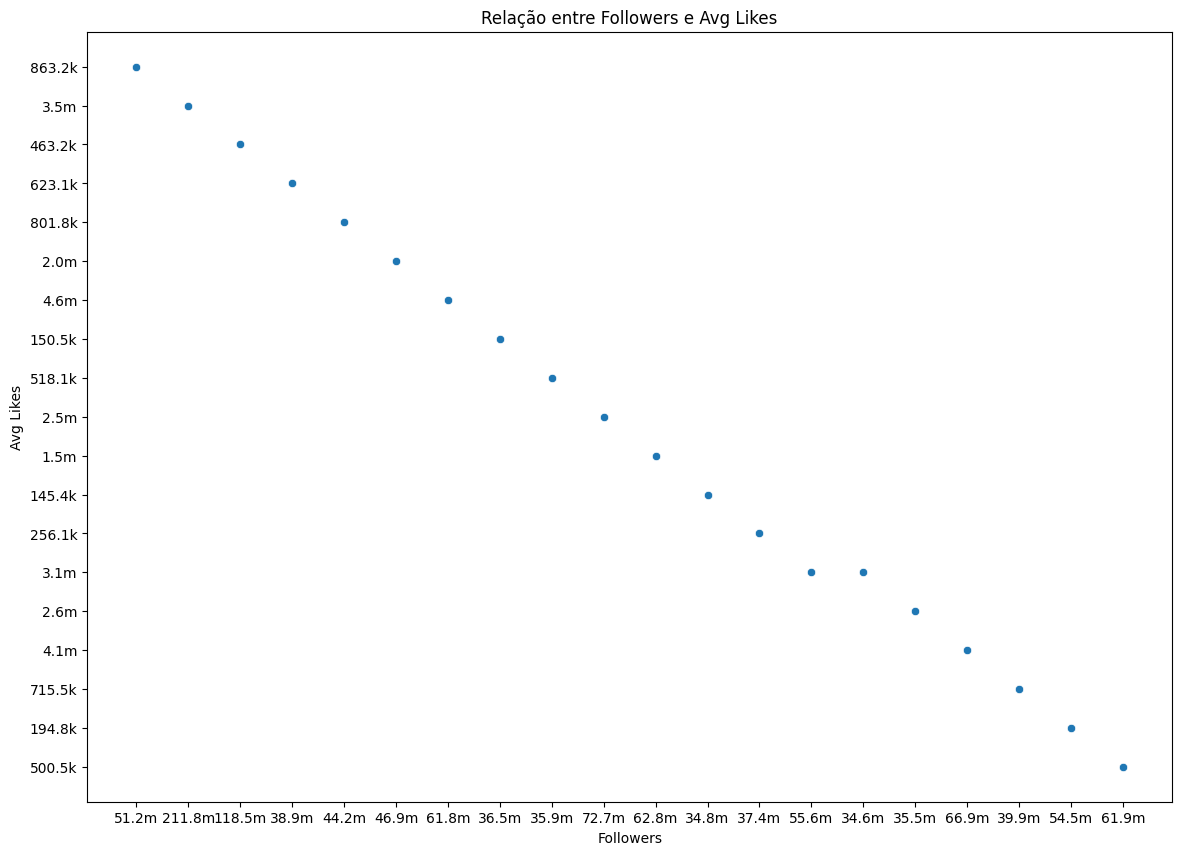

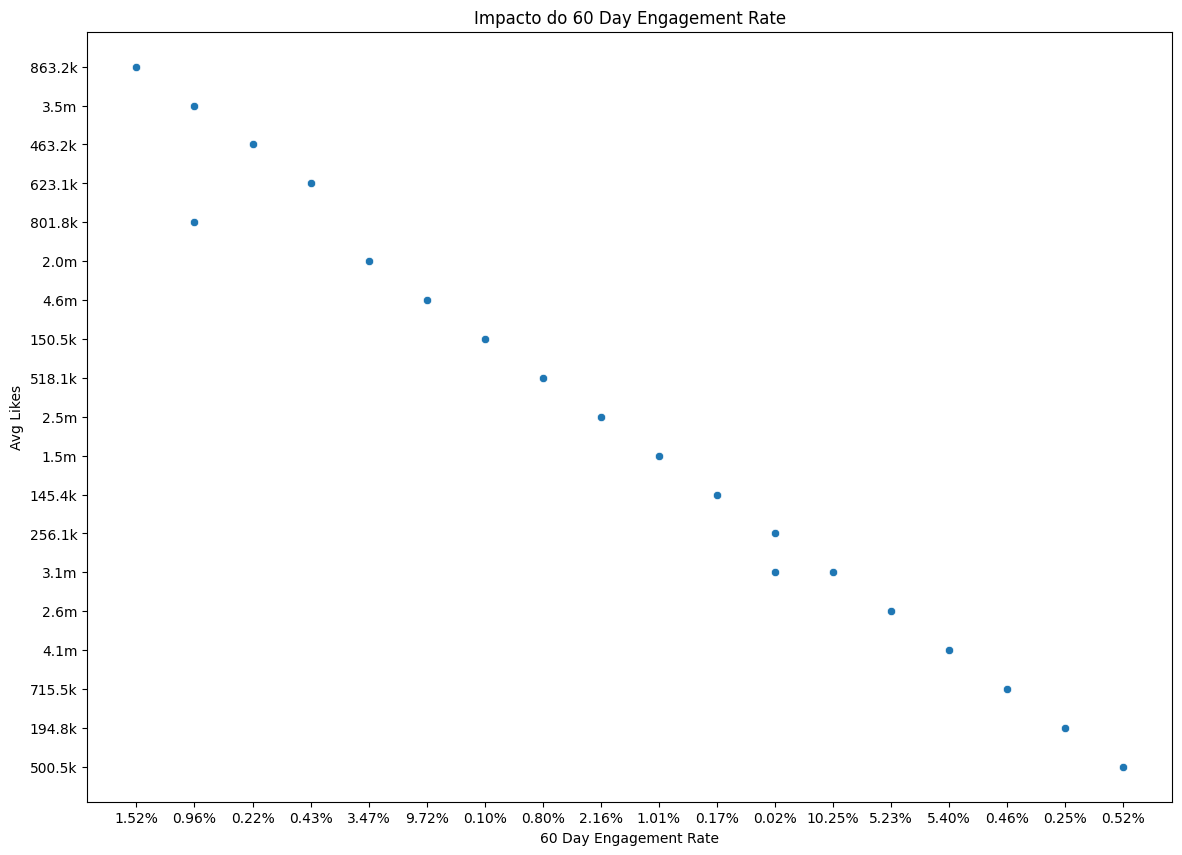

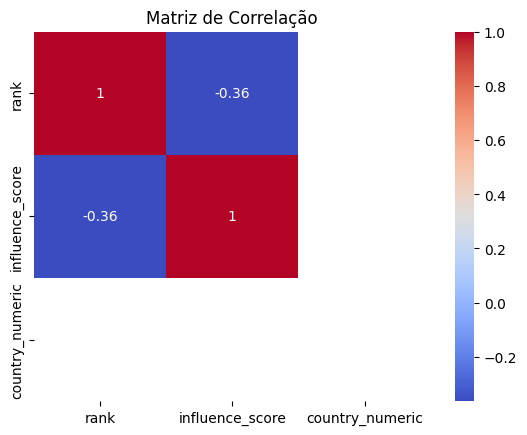

<Figure size 1400x1000 with 0 Axes>

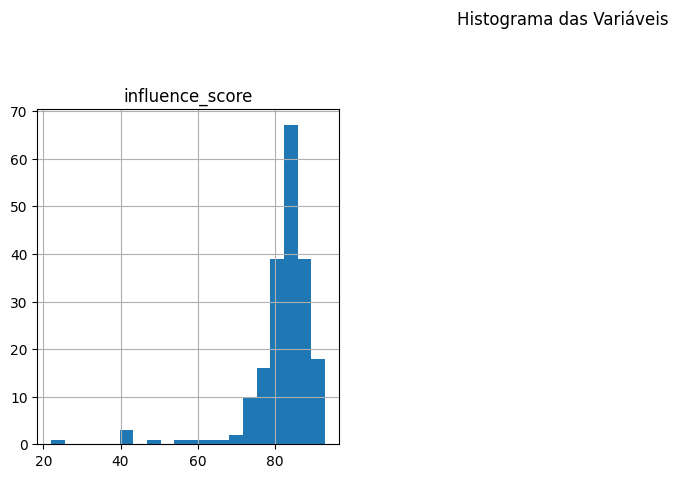

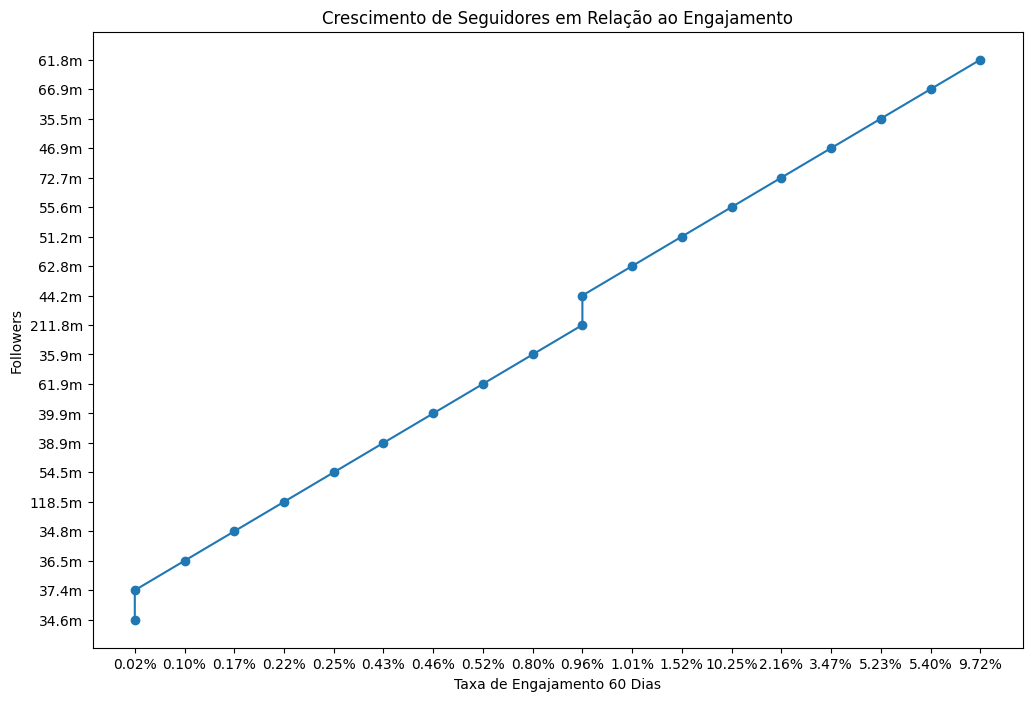

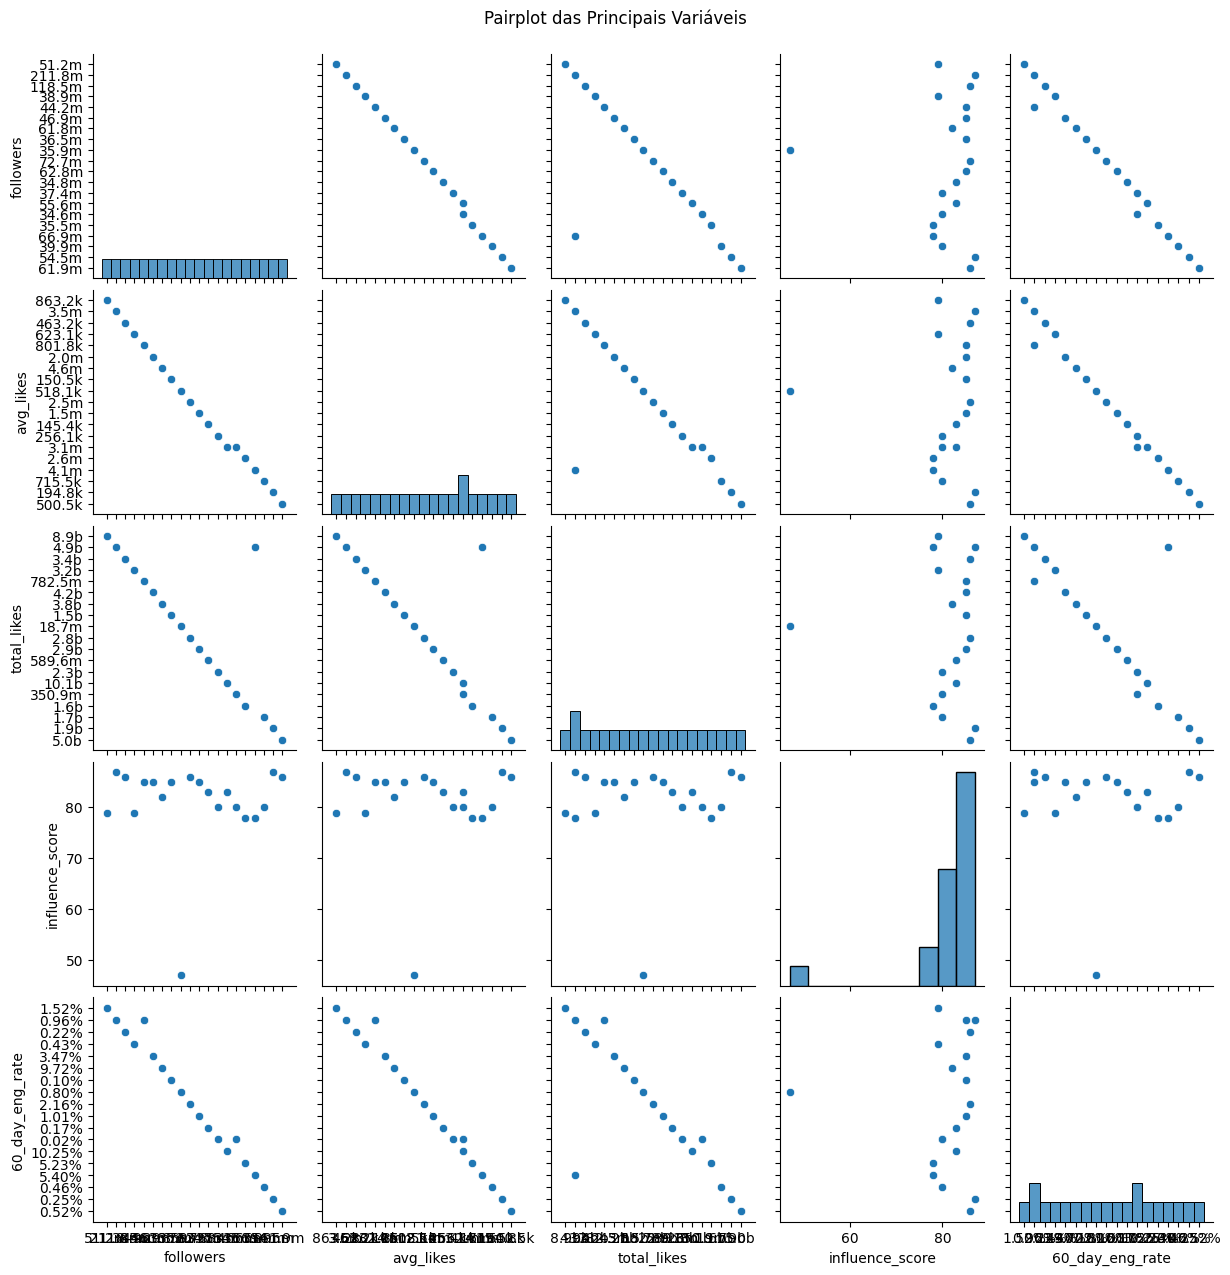

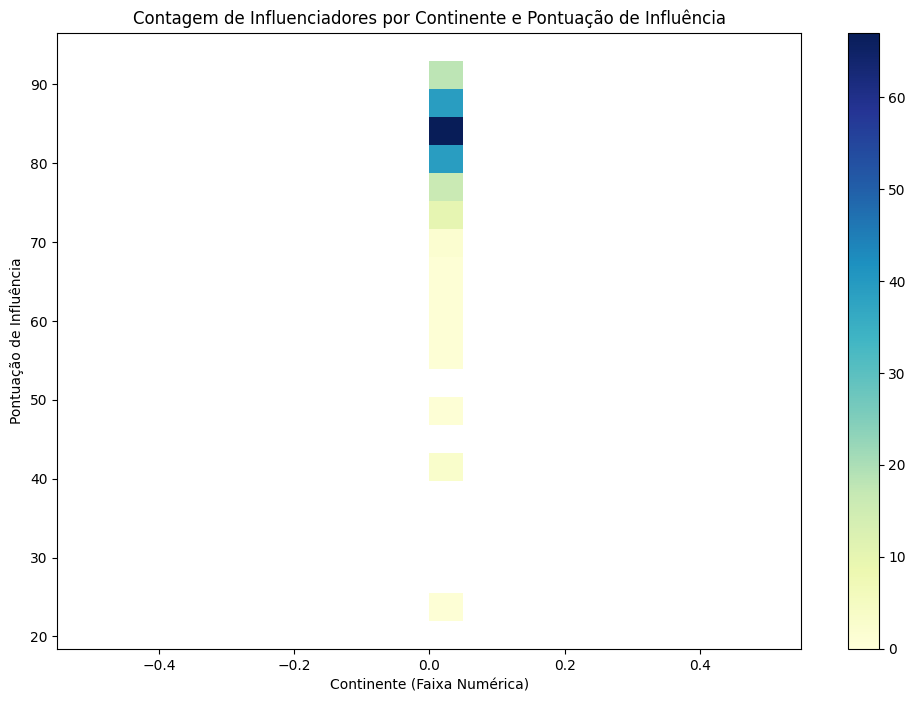

In [3]:
# Transformação de "country" em faixas numéricas por continente
continent_mapping = {
    'South America': (1, 9),
    'North America': (20, 29),
    'Europe': (40, 49),
    'Asia': (50, 59),
    'Africa': (60, 69),
    'Oceania': (70, 79)
}

# Função para mapear o país para o continente
def map_country_to_continent_range(country):
    # Verificar se o valor é nulo
    if pd.isnull(country):
        return 0  # Valor padrão para valores nulos

    # Ajustar o mapeamento com base no continente
    for continent, (start, end) in continent_mapping.items():
        if continent in country:  # Ajuste o critério conforme o necessário
            return np.random.randint(start, end + 1)
    return 0  # Valor padrão caso não encontre o país no mapeamento

# Aplicar a função
df['country_numeric'] = df['country'].apply(map_country_to_continent_range)

# Verificar a transformação
print(df[['country', 'country_numeric']].head())

sample_df = df.sample(frac=0.1,random_state=42)

# Análise Exploratória e Visualizações
plt.figure(figsize=(14,10))
sns.scatterplot(x='followers', y='avg_likes', data=sample_df)
plt.title('Relação entre Followers e Avg Likes')
plt.xlabel('Followers')
plt.ylabel('Avg Likes')
plt.show()

plt.figure(figsize=(14,10))
sns.scatterplot(x='60_day_eng_rate', y='avg_likes', data=sample_df)
plt.title('Impacto do 60 Day Engagement Rate')
plt.xlabel('60 Day Engagement Rate')
plt.ylabel('Avg Likes')
plt.show()

# Selecionar apenas colunas numéricas para a matriz de correlação
numeric_df = df.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix = numeric_df.corr()

# Visualizar a matriz de correlação
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


# Histograma das variávies principais
plt.figure(figsize=(14,10))
numeric_columns = ['followers', 'avg_likes', 'total_likes', '60_day_eng_rate', 'influence_score']
df[numeric_columns].hist(bins=20, figsize=(14,10), layout=(2,3))
plt.suptitle('Histograma das Variáveis')
plt.show()

#Gráfico de Linha de Crescimento de Seguidores (Followers)
df_sorted = sample_df.sort_values('60_day_eng_rate')  # Ordenar por engajamento
plt.figure(figsize=(12, 8))
plt.plot(df_sorted['60_day_eng_rate'], df_sorted['followers'], marker='o', linestyle='-')
plt.title('Crescimento de Seguidores em Relação ao Engajamento')
plt.xlabel('Taxa de Engajamento 60 Dias')
plt.ylabel('Followers')
plt.show()


#Pairplot para Visualizar Relações Múltiplas
sns.pairplot(sample_df, vars=['followers', 'avg_likes', 'total_likes', 'influence_score', '60_day_eng_rate'])
plt.suptitle('Pairplot das Principais Variáveis', y=1.02)
plt.show()

#Mapa de Calor de Contagem de Influenciadores por Continente e Pontuação de Influência
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='country_numeric', y='influence_score', bins=20, cbar=True, cmap='YlGnBu')
plt.title('Contagem de Influenciadores por Continente e Pontuação de Influência')
plt.xlabel('Continente (Faixa Numérica)')
plt.ylabel('Pontuação de Influência')
plt.show()






# Pré-processamento dos dados

Aqui serão feitos os devidos tratamentos na base de dados antes de submeter a mesma ao treinmaneto do KNN

In [6]:
def convert_to_numeric(value):
    if isinstance(value, str):
        if 'b' in value:
            return float(value.replace('b', '')) * 1_000_000_000
        elif 'm' in value:
            return float(value.replace('m', '')) * 1_000_000
        elif 'k' in value:
            return float(value.replace('k', '')) * 1_000
    return float(value)

# Aplicar a conversão nas colunas
df['followers'] = df['followers'].apply(convert_to_numeric)
df['avg_likes'] = df['avg_likes'].apply(convert_to_numeric)
df['total_likes'] = df['total_likes'].apply(convert_to_numeric)

def convert_percentage_to_float(value):
    if isinstance(value, str) and '%' in value:
        return float(value.replace('%', '')) / 100
    return float(value)

# Aplicar a conversão na coluna '60_day_eng_rate'
df['60_day_eng_rate'] = df['60_day_eng_rate'].apply(convert_percentage_to_float)
df['60_day_eng_rate'] = df['60_day_eng_rate'].astype(float)  # Garantir que está como float

# Criar nova variável de interação
df['followers_x_engagement'] = df['followers'] * df['60_day_eng_rate']

# Remover outliers nas principais variáveis numéricas
# Define os limites para cada variável usando o IQR
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers(df, ['followers', 'avg_likes', 'total_likes', 'followers_x_engagement'])

# Selecionar as features e o target
X = df[['followers', 'avg_likes', 'total_likes', 'country_numeric', 'followers_x_engagement']]
y = df['influence_score']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Implementação do KNN

Nessa seção dedicamos a implentação completa do KNN e no fim do treinamento as metricas MAE, MSE e RMSE são exibidas na tela.

Melhor k: 9, Melhor métrica de distância: manhattan
MAE: 5.305555555555556, MSE: 42.28189300411524, RMSE: 6.502452845205049


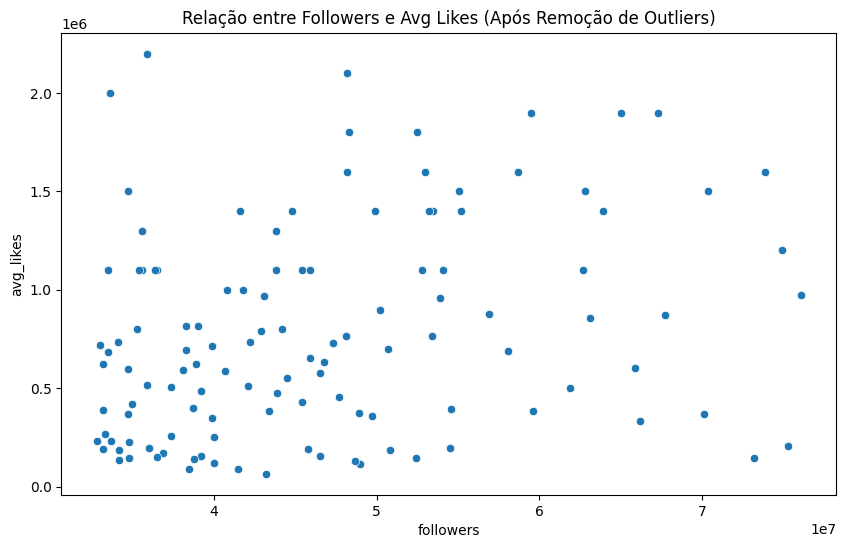

In [7]:
# Normalizar os dados com StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Implementar o kNN
knn = KNeighborsRegressor()

# GridSearchCV para encontrar os melhores hiperparâmetros
param_grid = {'n_neighbors': [3, 5, 7, 9, 10, 12, 15, 18, 20], 'metric': ['euclidean', 'manhattan']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Melhor modelo
best_knn = grid_search.best_estimator_
print(f"Melhor k: {grid_search.best_params_['n_neighbors']}, Melhor métrica de distância: {grid_search.best_params_['metric']}")

# Avaliar no conjunto de teste
y_pred = best_knn.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Visualização após remoção de outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x='followers', y='avg_likes', data=df)
plt.title('Relação entre Followers e Avg Likes (Após Remoção de Outliers)')
plt.show()

# Comparação com diferentes escalas 

Aqui separamos uma seção apenas para comparar os diferentes escalas


In [8]:
# Criar uma função para rodar o GridSearchCV com diferentes escalas
def evaluate_scaler(scaler, X_train, X_test, y_train, y_test):
    # Aplicar a escala escolhida
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Implementar o kNN com GridSearchCV para otimizar hiperparâmetros
    knn = KNeighborsRegressor()
    param_grid = {'n_neighbors': range(10, 21), 'metric': ['euclidean', 'manhattan']}
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    
    # Avaliar o melhor modelo no conjunto de teste
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return best_knn, mae, mse, rmse

# Escala RobustScaler
robust_scaler = RobustScaler()
best_knn_robust, mae_robust, mse_robust, rmse_robust = evaluate_scaler(robust_scaler, X_train, X_test, y_train, y_test)
print("RobustScaler")
print(f"Melhor k: {best_knn_robust.n_neighbors}, Melhor métrica de distância: {best_knn_robust.metric}")
print(f"MAE: {mae_robust}, MSE: {mse_robust}, RMSE: {rmse_robust}")

# Escala MaxAbsScaler
maxabs_scaler = MaxAbsScaler()
best_knn_maxabs, mae_maxabs, mse_maxabs, rmse_maxabs = evaluate_scaler(maxabs_scaler, X_train, X_test, y_train, y_test)
print("\nMaxAbsScaler")
print(f"Melhor k: {best_knn_maxabs.n_neighbors}, Melhor métrica de distância: {best_knn_maxabs.metric}")
print(f"MAE: {mae_maxabs}, MSE: {mse_maxabs}, RMSE: {rmse_maxabs}")

# Escala Normalizer
normalizer = Normalizer()
best_knn_normalizer, mae_normalizer, mse_normalizer, rmse_normalizer = evaluate_scaler(normalizer, X_train, X_test, y_train, y_test)
print("\nNormalizer")
print(f"Melhor k: {best_knn_normalizer.n_neighbors}, Melhor métrica de distância: {best_knn_normalizer.metric}")
print(f"MAE: {mae_normalizer}, MSE: {mse_normalizer}, RMSE: {rmse_normalizer}")

RobustScaler
Melhor k: 10, Melhor métrica de distância: manhattan
MAE: 5.104166666666667, MSE: 37.85541666666668, RMSE: 6.152675569755542

MaxAbsScaler
Melhor k: 19, Melhor métrica de distância: euclidean
MAE: 5.166666666666665, MSE: 36.61357340720221, RMSE: 6.050915088414496

Normalizer
Melhor k: 19, Melhor métrica de distância: manhattan
MAE: 4.796052631578947, MSE: 29.04605263157894, RMSE: 5.3894389904310955


# Exibição extra de gráficos

Aqui resevamos uma seção para a exibição de outros gráficos 

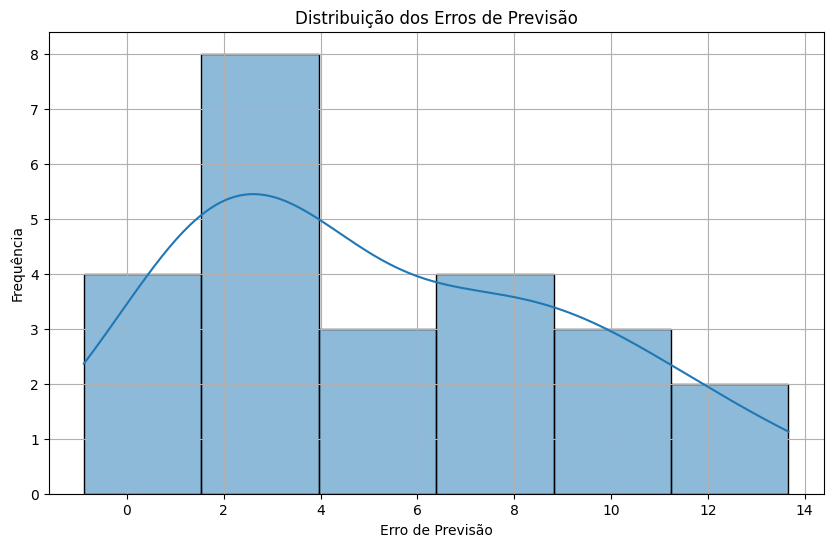

In [9]:
#Distribuição dos Erros de Previsão

# Calcular os erros de previsão
y_pred = best_knn.predict(X_test_scaled)
errors = y_test - y_pred

# Plotar o histograma dos erros
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribuição dos Erros de Previsão')
plt.xlabel('Erro de Previsão')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Gráfico de Dispersão: Previsões vs. Valores Reais
Este gráfico mostra a relação entre as previsões e os valores reais.

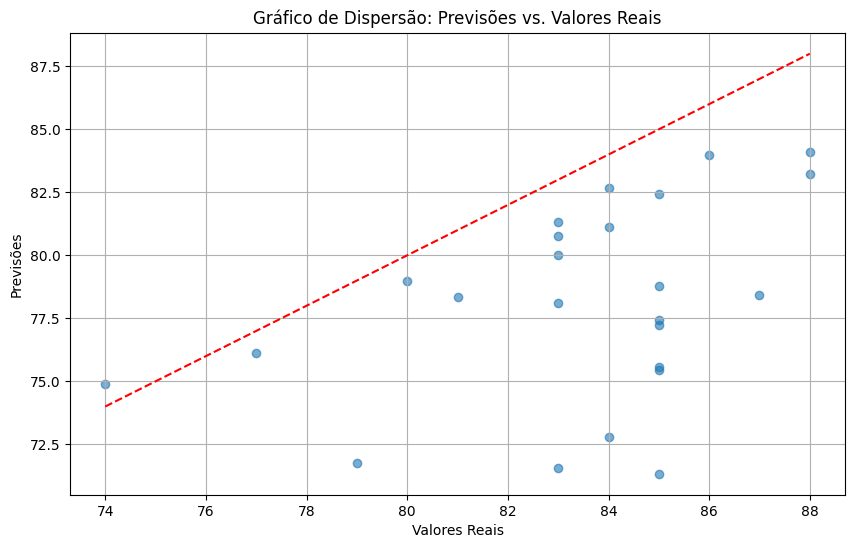

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Gráfico de Dispersão: Previsões vs. Valores Reais')
plt.grid(True)
plt.show()


# Curva de Validação Cruzada (Learning Curve)
Aqui, usamos learning_curve do sklearn.model_selection para verificar o desempenho conforme aumenta o número de dados de treinamento.

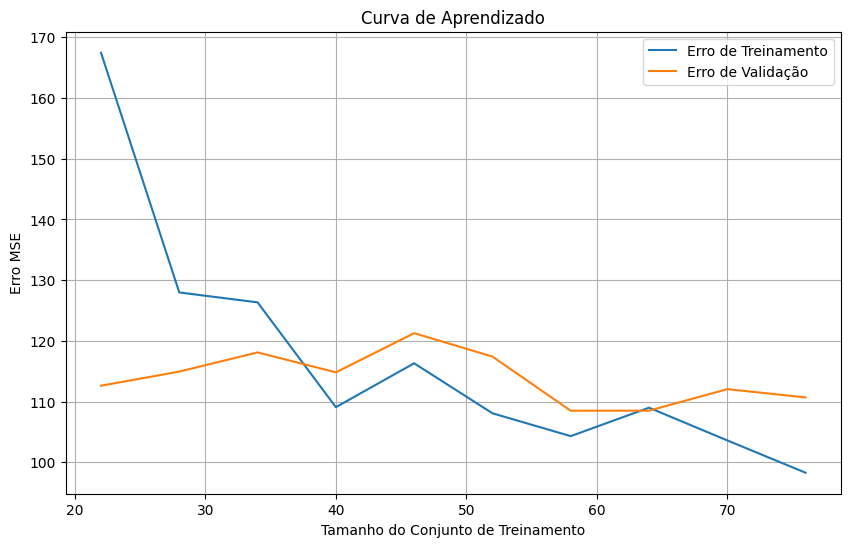

In [15]:
from sklearn.model_selection import learning_curve

# Ajustar `train_sizes` para evitar conjuntos de treinamento menores que `n_neighbors`
train_sizes, train_scores, test_scores = learning_curve(
    best_knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.3, 1.0, 10)  # Começa de 30% para garantir um tamanho adequado
)

# Calcular média e desvio padrão
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plotar a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Erro de Treinamento')
plt.plot(train_sizes, test_errors, label='Erro de Validação')
plt.xlabel('Tamanho do Conjunto de Treinamento')
plt.ylabel('Erro MSE')
plt.title('Curva de Aprendizado')
plt.legend()
plt.grid(True)
plt.show()



# Curva de Erro vs. k (Número de Vizinhos)
Esse código realiza um loop sobre diferentes valores de k, treina o modelo, e calcula o erro de teste para cada valor de

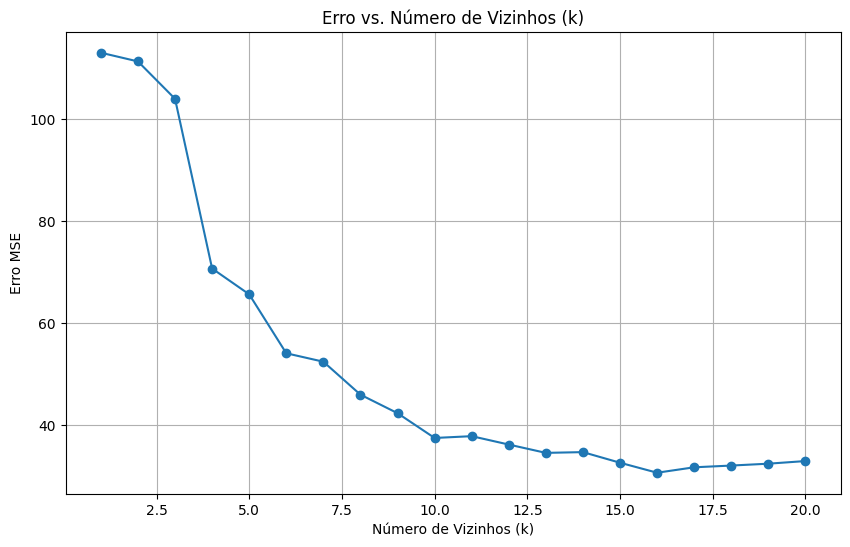

In [13]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Lista para armazenar os erros
errors = []
k_values = range(1, 21)  # Ajuste o intervalo conforme necessário

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, metric='manhattan')  # Use a métrica que funcionou melhor
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)

# Plotar a curva de erro
plt.figure(figsize=(10, 6))
plt.plot(k_values, errors, marker='o')
plt.title('Erro vs. Número de Vizinhos (k)')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Erro MSE')
plt.grid(True)
plt.show()
